## Asymmetric, RBF only kernel

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['savefig.dpi'] = 140
mpl.rcParams['figure.dpi'] = 140
import numpy as np
# our own modules
import gp_emulator
import test_simulation
import p1d_arxiv
import copy

In [2]:
## Sim suite
basedir="/p1d_emulator/sim_suites/Australia20/"
skewers_label='Ns500_wM0.05'
p1d_label=None
paramList=['mF', 'sigT_Mpc', 'gamma', 'kF_Mpc', 'Delta2_p', 'n_p']
# specify k range
kmax_Mpc=8

In [3]:
test_sim_number=14 ## Which sim to drop out of the training set and perform the predictions on

In [4]:
# Set up emulator training set
z_max=4
# do not use test_sim_num that was used in generating mock data
arxiv=p1d_arxiv.ArxivP1D(basedir=basedir,drop_sim_number=test_sim_number,
                            drop_tau_rescalings=True,z_max=z_max,
                            drop_temp_rescalings=True,skewers_label=skewers_label)

In [5]:
## Our standard emulator
emu=gp_emulator.GPEmulator(basedir,p1d_label,skewers_label,z_max=z_max,
                                verbose=False,paramList=paramList,train=True,asymmetric_kernel=False,rbf_only=False,
                                emu_type="k_bin",passArxiv=arxiv,checkHulls=True,
                                kmax_Mpc=kmax_Mpc)

 /Users/font/opt/anaconda3/envs/lya_cosmo/lib/python3.8/site-packages/paramz/parameterized.py:61: RuntimeWarning:Don't forget to initialize by self.initialize_parameter()!


Training GP on 261 points
Optimised


In [6]:
## RBF only, asymmetric kernel
emu_kern=gp_emulator.GPEmulator(basedir,p1d_label,skewers_label,z_max=z_max,
                                verbose=False,paramList=paramList,train=True,asymmetric_kernel=True,rbf_only=True,
                                emu_type="k_bin",passArxiv=arxiv,checkHulls=True,
                                kmax_Mpc=kmax_Mpc)

Training GP on 261 points
Optimised


In [7]:
test_sim=test_simulation.TestSimulation(basedir=basedir,sim_label=test_sim_number,skewers_label=skewers_label,z_max=4,kmax_Mpc=8,kp_Mpc=0.7)

In [8]:
## z list
zs=np.linspace(4,2,9)

In [9]:
## General plot params
y_min=0.95
y_max=1.05

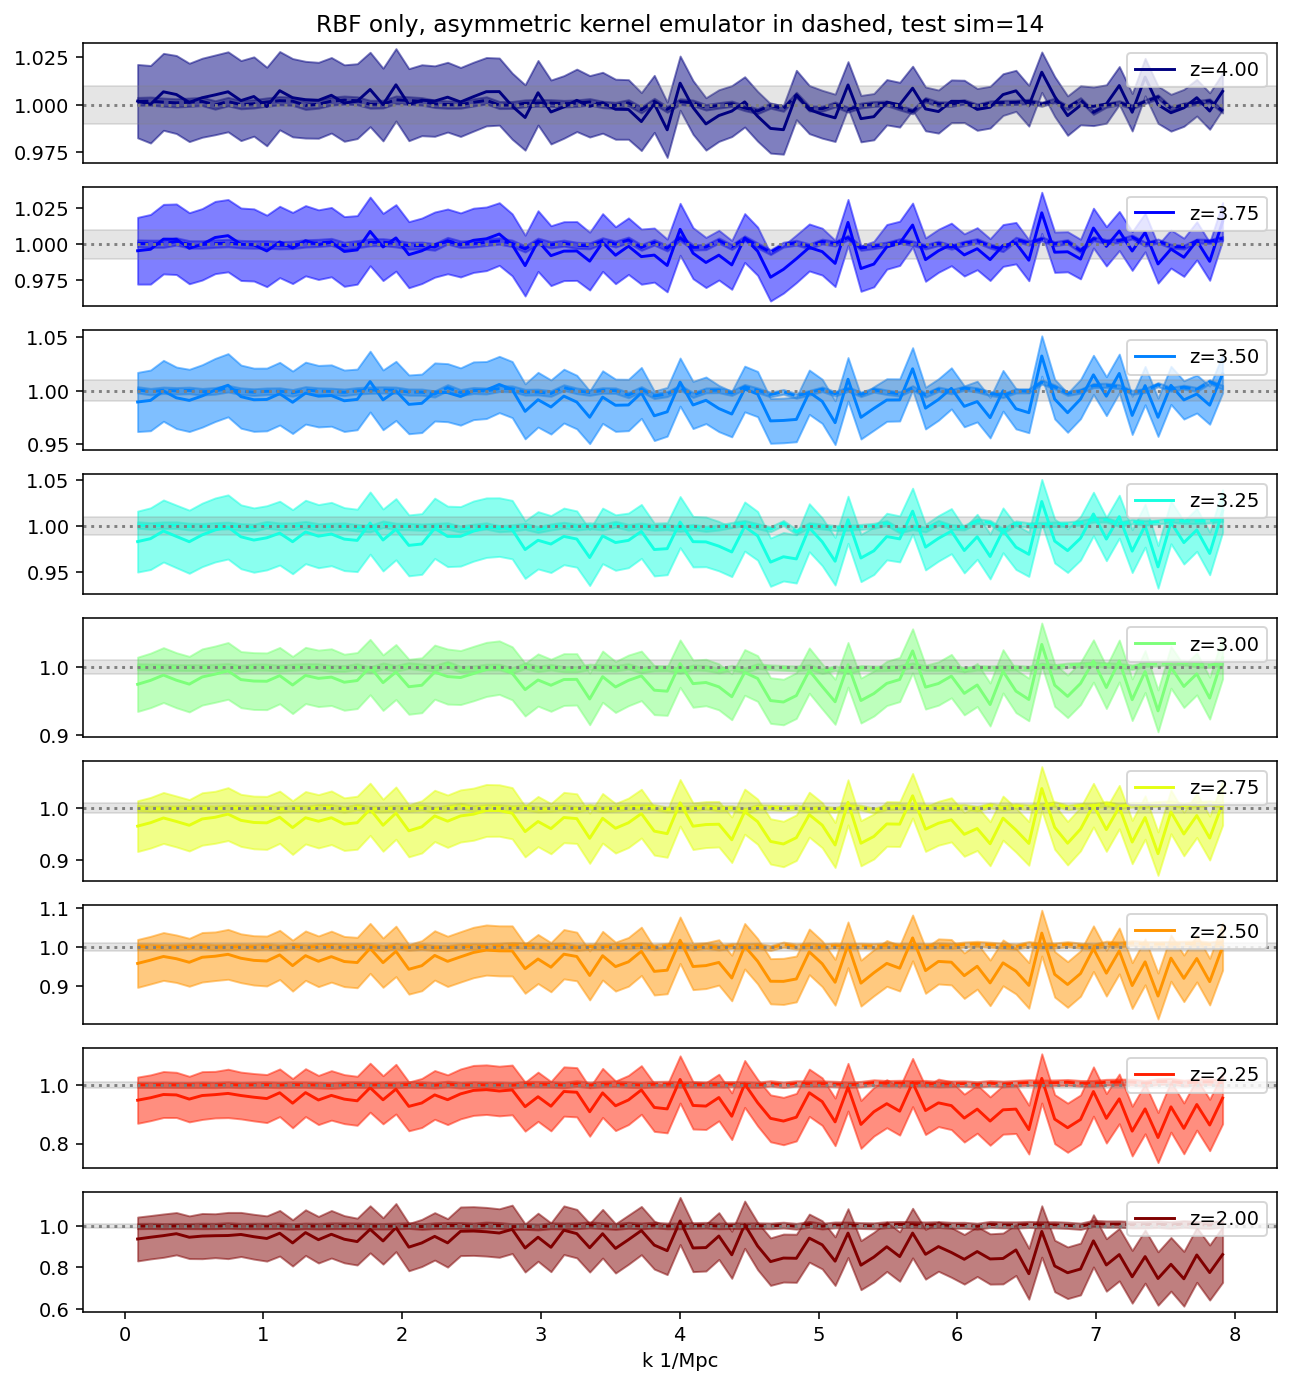

In [10]:
plt.figure(figsize=[11,12])
dex=0
for aa,z in enumerate(zs):
    ## Set up plot
    plt.subplot(len(zs),1,aa+1)
    if aa==0:
        plt.title("RBF only, asymmetric kernel emulator in dashed, test sim=%s" % str(test_sim_number))
    col = plt.cm.jet(dex/(len(zs)-1))
    dex+=1
    
    ## Get truth from test_simulation object
    k_sim,pk_sim=test_sim.get_p1d_Mpc(z)
    k_true=k_sim[0][1:] ## Remove k=0 bin
    pk_true=pk_sim[1:]
    
    ## Get emulator prediction
    emu_call=test_sim.get_emulator_calls(z)
    pred,err=emu.emulate_p1d_Mpc(emu_call,k_true,True,z)
    
    pred_kern,err_kern=emu_kern.emulate_p1d_Mpc(emu_call,k_true,True,z)
    
    ## Plot ratio of prediction vs truth and uncertainty region
    plt.plot(k_true,pred/pk_true,color=col,linestyle="solid",label="z=%.2f" % z)
    plt.fill_between(k_true,(pred+np.sqrt(np.diag(err)))/pk_true,
            (pred-np.sqrt(np.diag(err)))/pk_true,alpha=0.5,color=col)

    ## Plot ratio of prediction vs truth and uncertainty region
    
    plt.plot(k_true,pred_kern/pk_true,color=col,linestyle="dashed")
    plt.fill_between(k_true,(pred_kern+np.sqrt(np.diag(err_kern)))/pk_true,
            (pred_kern-np.sqrt(np.diag(err_kern)))/pk_true,alpha=0.5,color=col)
    
    ## 1% region and formatting things
    plt.axhspan(0.99,1.01,color="gray",alpha=0.2)
    plt.axhline(1,linestyle=":",color="gray")
    #plt.ylim(y_min,y_max)
    plt.legend(loc="upper right")
    if aa != 8:
        plt.xticks([])

plt.xlabel("k 1/Mpc")
plt.savefig("new_emu_test.pdf")

Print hyperparamters

In [11]:
emu.gp.to_dict(False)

{'name': 'GP regression',
 'class': 'GPy.models.GPRegression',
 'X': None,
 'Y': None,
 'kernel': {'input_dim': 6,
  'active_dims': [0, 1, 2, 3, 4, 5],
  'name': 'sum',
  'useGPU': False,
  'parts': {0: {'input_dim': 6,
    'active_dims': [0, 1, 2, 3, 4, 5],
    'name': 'linear',
    'useGPU': False,
    'class': 'GPy.kern.Linear',
    'variances': [25.889313578288743],
    'ARD': False},
   1: {'input_dim': 6,
    'active_dims': [0, 1, 2, 3, 4, 5],
    'name': 'rbf',
    'useGPU': False,
    'variance': [28.737628604483803],
    'lengthscale': [1.056025821761365],
    'ARD': False,
    'class': 'GPy.kern.RBF',
    'inv_l': False}},
  'class': 'GPy.kern.Add'},
 'likelihood': {'name': 'Gaussian_noise',
  'gp_link_dict': {'class': 'GPy.likelihoods.link_functions.Identity'},
  'class': 'GPy.likelihoods.Gaussian',
  'variance': [6.086100696201104e-06]},
 'inference_method': {'class': 'GPy.inference.latent_function_inference.exact_gaussian_inference.ExactGaussianInference'}}

In [12]:
emu_kern.gp.to_dict(False)

{'name': 'GP regression',
 'class': 'GPy.models.GPRegression',
 'X': None,
 'Y': None,
 'kernel': {'input_dim': 6,
  'active_dims': [0, 1, 2, 3, 4, 5],
  'name': 'rbf',
  'useGPU': False,
  'variance': [23.156625003499055],
  'lengthscale': [0.47896671292314047,
   3.640482919778404,
   3.1439801802763623,
   1.393094429312821,
   2.0576072320652403,
   11.564827159289669],
  'ARD': True,
  'class': 'GPy.kern.RBF',
  'inv_l': False},
 'likelihood': {'name': 'Gaussian_noise',
  'gp_link_dict': {'class': 'GPy.likelihoods.link_functions.Identity'},
  'class': 'GPy.likelihoods.Gaussian',
  'variance': [9.0477415662263e-06]},
 'inference_method': {'class': 'GPy.inference.latent_function_inference.exact_gaussian_inference.ExactGaussianInference'}}